<a href="https://colab.research.google.com/github/Himanshu-kashyap/Pytorch-Tutorials/blob/master/2.2%20Pytorch_CNN_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of images using cifar dataset


In [14]:
import torch
import numpy as np
on_gpu = torch.cuda.is_available()
if (torch.cuda.is_available()):
  print("on GPU")


on GPU


In [6]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0  # subprocesses to load data
batch_size = 20   # in amount of loading data 
valid_size = 0.2

transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))    # image = (image - mean) / std will make all values in range -1,1
])

train_data = datasets.CIFAR10('data',train = True,download = True,transform  = transform)
test_data = datasets.CIFAR10('data',train = False,download = True,transform = transform)


num_train = len(train)
indices = list(range(num_train))
np.random.shuffle(indices)  # shuffle the dataset

split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indices[split:],indices[:split]


#define samplers for validn and training 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# loading data using sampler

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,sampler = train_sampler,num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,sampler = valid_sampler,num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data,num_workers = num_workers,batch_size = batch_size)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']









Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt

def imshow(img):
  img = img*2 + 0.5  # undoing the normalization
  plt.imshow(np.transpose(img,(1,2,0))) # convert from tensor image

In [0]:
data_iter = iter(train_loader)
images,labels = data_iter.next()

# convert images to numpy images for display
images = images.numpy()

#plotting the images
fig = plt.figure(figsize = (25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2,20/2,i+1,xticks =[],yticks = [])
  imshow(images[i])
  ax.set_title(classes[labels[i]])

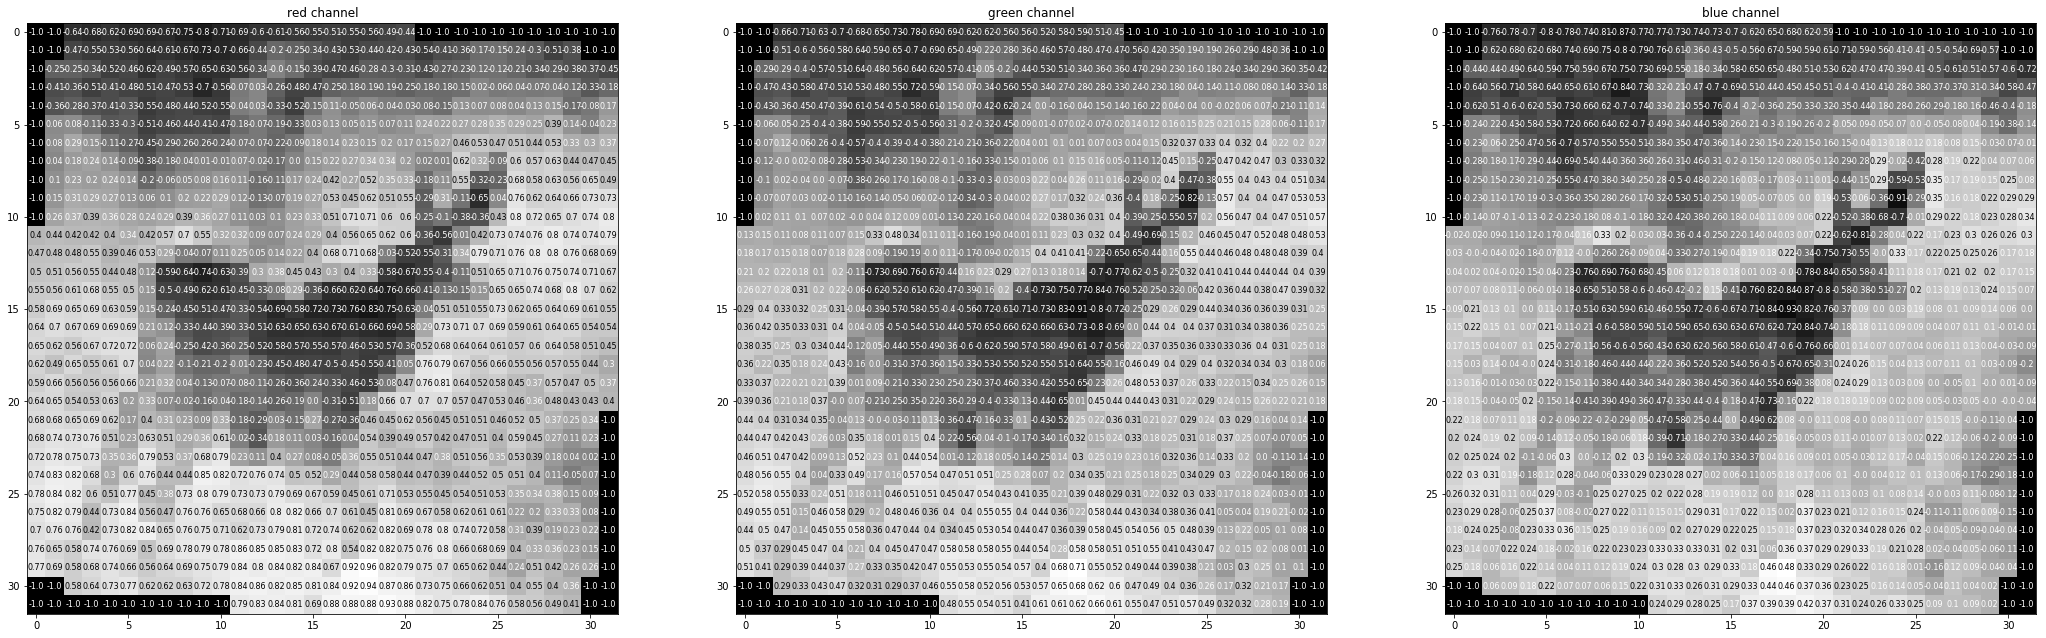

In [12]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')
                     


We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by **(W−F+2P)/S+1.**

# Defining Archirtecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    
    self.conv1 = nn.Conv2d(3,16,3,padding = 1) # conv layer sees 32 X 32 X 3 image with 3 size conv  output depth, extract features, conv size, padding
    self.conv2 = nn.Conv2d(16,32,3,padding = 1) # output is calculated w-f+2p/(s+1) sees 16X16X16 tensor
    self.conv3 = nn.Conv2d(32,64,3,padding = 1) # 8,8,32
    
    # maxpooling layer
    self.pool = nn.MaxPool2d(2,2)
    
    # fully connected layer
    self.fc1 = nn.Linear(64*4*4,500)  # 64*4*4 -> 500
    self.fc2 = nn.Linear(500,10)
    
    #drop out layer
    self.dropout = nn.Dropout(0.25)
  
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x))) 
    
    # flatten image input
    x = x.view(-1,64 * 4* 4)
    
    # dropout layer
    x = self.dropout(x)
    
    # add 1st hidden layer with relu
    x = F.relu(self.fc1(x))
    
    # add drop out 
    x = self.dropout(x)
    
    # 2nd hidden layer with relu activation function
    x = self.fc2(x) 
    
    return x

model = Net()  
print(model)

if on_gpu:
  model.cuda()
    

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


## Loss and optimizer

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr = 0.01)

## training the network

In [0]:
??train_loader

In [0]:
n_epochs = 30
valid_loss_min = np.Inf # to track change in validation loss

for epoch in range(0,n_epochs+1):
  
  train_loss = 0
  valid_loss =0
  
  ### training model
  model.train()
  for batch_idx, (data,target) in enumerate(train_loader):  # loader returns 1st output as batch index
    
    if on_gpu:
      data,target = data.cuda(),target.cuda()
      
      optimizer.zero_grad()
      output = model(data)
      
      loss = criterion(output,target)
      
      loss.backward()       # backward pass compute gradient of loss wrt parameters
      optimizer.step()       # take an optimizer step
      
      train_loss += loss.item()*data.size(0)  # update training loss

   ### evaluate the model
  model.eval()
  
  for batch_idx, (data,target) in enumerate(valid_loader):
    if on_gpu:
      data,target = data.cuda(),target.cuda()
    
    output = model(data)
    loss = criterion(output,target)
     
    valid_loss += loss.item()* data.size(0) # upgrade avg validn loss
    
 # calculating average losses
  
  train_loss = train_loss/ len(train_loader.sampler)
  valid_loss = valid_loss/ len(valid_loader.sampler)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 1.692655 	Validation Loss: 1.565967
Validation loss decreased (inf --> 1.565967).  Saving model ...
Epoch: 1 	Training Loss: 1.510739 	Validation Loss: 1.447020
Validation loss decreased (1.565967 --> 1.447020).  Saving model ...
Epoch: 2 	Training Loss: 1.401117 	Validation Loss: 1.371441
Validation loss decreased (1.447020 --> 1.371441).  Saving model ...
Epoch: 3 	Training Loss: 1.319982 	Validation Loss: 1.304674
Validation loss decreased (1.371441 --> 1.304674).  Saving model ...
Epoch: 4 	Training Loss: 1.250912 	Validation Loss: 1.163296
Validation loss decreased (1.304674 --> 1.163296).  Saving model ...
Epoch: 5 	Training Loss: 1.197568 	Validation Loss: 1.123495
Validation loss decreased (1.163296 --> 1.123495).  Saving model ...
Epoch: 6 	Training Loss: 1.146701 	Validation Loss: 1.111271
Validation loss decreased (1.123495 --> 1.111271).  Saving model ...
Epoch: 7 	Training Loss: 1.101800 	Validation Loss: 1.038877
Validation loss decreased (1.11127